### Libraries

In [442]:
import math
import numpy as np

import pandas 
# import plotly.express as px
import matplotlib.pyplot as plt

### Constants

In [443]:
# @title Gauss-Laguerre constants
# Notation: (abscissa, weight)
GAUSS_LAGUERRE = [
    (0.222847, 0.458964),
    (1.188932, 0.417),
    (2.992736, 0.113373),
    (5.775144, 0.0103992),
    (9.837467, 0.000261017),
    (15.982874, 0.000000898548)
]

N = 6

### Functions

In [444]:
# @title Weibull distribution function
def f_Weibull (t, k, mu):
    f = lambda x, k : x ** (1/k)

    area = 0

    for i in range(N):
        area += GAUSS_LAGUERRE[i][1] * f(GAUSS_LAGUERRE[i][0], k)
    
    varLambda = mu / area

    return (k/varLambda) * ((t/varLambda) ** k-1) * (math.e ** ((t/varLambda) ** k))

In [445]:
# @title Integral of Weibull function
def cdf_Weibull (t, k, mu):
    f = lambda x, k, mu : (math.e ** x) * f_Weibull(x, k, mu)

    area = 0
    
    for i in range(N):
        x = - GAUSS_LAGUERRE[i][0] + t
        area += GAUSS_LAGUERRE[i][1] * f(x, k, mu)

    return area

In [446]:
# Inverse survivability
# solved as root-finding problem using bisection method
def surv_inv (alpha, a, b, k, mu):
    isDiffSign = lambda x1, x2 : np.sign(x1) != np.sign(x2)
    f = lambda t : cdf_Weibull(t, k, mu) - alpha

    tol = 1.0e-9

    fa = f(a)
    if fa == 0.0:
        return a
    
    fb = f(b)
    if fb == 0.0:
        return b
    
    if not isDiffSign(fa, fb):
       return None
    
    n = int (math.ceil (math.log(abs(b-a) / tol) / math.log(2.0)))

    for i in range(n):
        c = 0.5 * (a + b)
        fc = f(c)

        # if (abs(fc) > abs(fa)) and (abs(fc) > abs(fb)):
        #     return None

        if fc == 0.0:
            return c

        if isDiffSign(fa, fc):
            a = c
            fa = fc
        
        elif isDiffSign(fb, fc):
            b = c
            fb = fc

    return 0.5 * (a+b)

### Evaluation

In [447]:
# Average life expectancy
expected_value = 78

# List for values
y_t_decr = []
y_t_cons = []
y_t_incr = []
x_values = []

In [448]:
# For alpha in (0,1) with 0.01 step
for alpha in range(1, 100, 1):
    alpha /= 100

    upper = 0
    lower = 100

    t_decr = surv_inv (alpha, upper, lower, 0.5, expected_value)
    t_cons = surv_inv (alpha, upper, lower, 1, expected_value)
    t_incr = surv_inv (alpha, upper, lower, 2, expected_value)

    x_values.append(alpha)

    y_t_decr.append(t_decr)
    y_t_cons.append(t_cons)
    y_t_incr.append(t_incr)

### Plotting

In [449]:
print(x_values)

print(y_t_decr)
print(y_t_cons)
print(y_t_incr)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
[75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0,

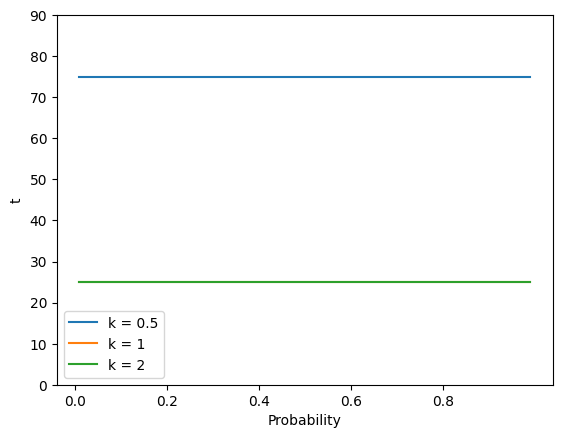

In [450]:
figures, axes = plt.subplots()

axes.plot(x_values, y_t_decr, label="k = 0.5")
axes.plot(x_values, y_t_cons, label="k = 1")
axes.plot(x_values, y_t_incr, label="k = 2")

axes.set_xlabel("Probability")
axes.set_ylabel("t")
axes.legend()

plt.xticks(np.arange(0, 1, step=0.2))
plt.yticks(np.arange(0, 100, step=10))

plt.show()